# Model System Notebook 1: RSoXS

Accompanying the RSoXS Tutorial paper titled "How to P-RSoXS" are four ipython notebooks covering
1. Experimental RSoXS data reduction and analysis
2. Experimental NEXAFS data reduction and optical constant derivation
3. Simulating RSoXS data using the NRSS library
4. Parameter sweeps of the NRSS model

**In order for these tutorial notebooks to work, you must download the associated data files from the NRSS github repo.** You can do this by going to https://github.com/usnistgov/NRSS/releases, clicking on the v2024.11.0 release, downloading the Data.zip file, and unzipping it into this directory

## Python libraries

In addition to the standard Python libraries commonly used in scientific computing, we also use [xarray](https://docs.xarray.dev/en/stable/) and [PyHyperScattering](https://github.com/usnistgov/PyHyperScattering). xarray provides labeled N-dimensional arrays and provides a pandas-like syntax for computing. PyHyperScattering is a library which builds off of xarray to provide "tools for hyperspectral x-ray and neutron scattering data loading, reduction, slicing, and visualization."

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import PyHyperScattering
import numpy as np
import pandas as pd

Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


In [2]:
plt.rcParams.update({'font.size':10, 'font.sans-serif':'Arial', 'mathtext.fontset':'custom'})
plt.rcParams['mathtext.rm'] = 'Arial'

## Data Loading

The experimental RSoXS data was taken at SST-1's RSoXS endstation. For this tutorial, detector images were aggregated into a xarray DataArray and saved into a netcdf file.

In [3]:
pol0_waxs = xr.open_dataarray('Data/RSoXS/CNT_pol0_WAXS_raw.nc')
pol90_waxs = xr.open_dataarray('Data/RSoXS/CNT_pol90_WAXS_raw.nc')

Here we can print out the coordinates of the DataArray for one of x-ray polarizations taken on the MWCNT samples to see scattering patterns were collected from 270 eV to 340 eV.

In [4]:
pol0_waxs

<xarray.DataArray 'Wide Angle CCD Detector_image' (pix_y: 1024, pix_x: 1026,
                                                   energy: 55)> Size: 462MB
[57784320 values with dtype=int64]
Coordinates:
  * energy   (energy) float64 440B 270.0 272.0 274.0 276.0 ... 320.0 330.0 340.0
    dark_id  float64 8B ...
  * pix_x    (pix_x) int64 8kB 0 1 2 3 4 5 6 ... 1020 1021 1022 1023 1024 1025
  * pix_y    (pix_y) int64 8kB 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
Attributes: (12/29)
    meas_time:             2022-12-13 02:32:09.597970
    sample_name:           PD_MWNT2
    rsoxs_config:          waxs
    beamcenter_x:          396.341
    beamcenter_y:          549.99
    sdd:                   39.19
    ...                    ...
    pixel2:                5.9999999999999995e-05
    poni1:                 0.0329994
    poni2:                 0.02378046
    rot1:                  0
    rot2:                  0
    rot3:                  0

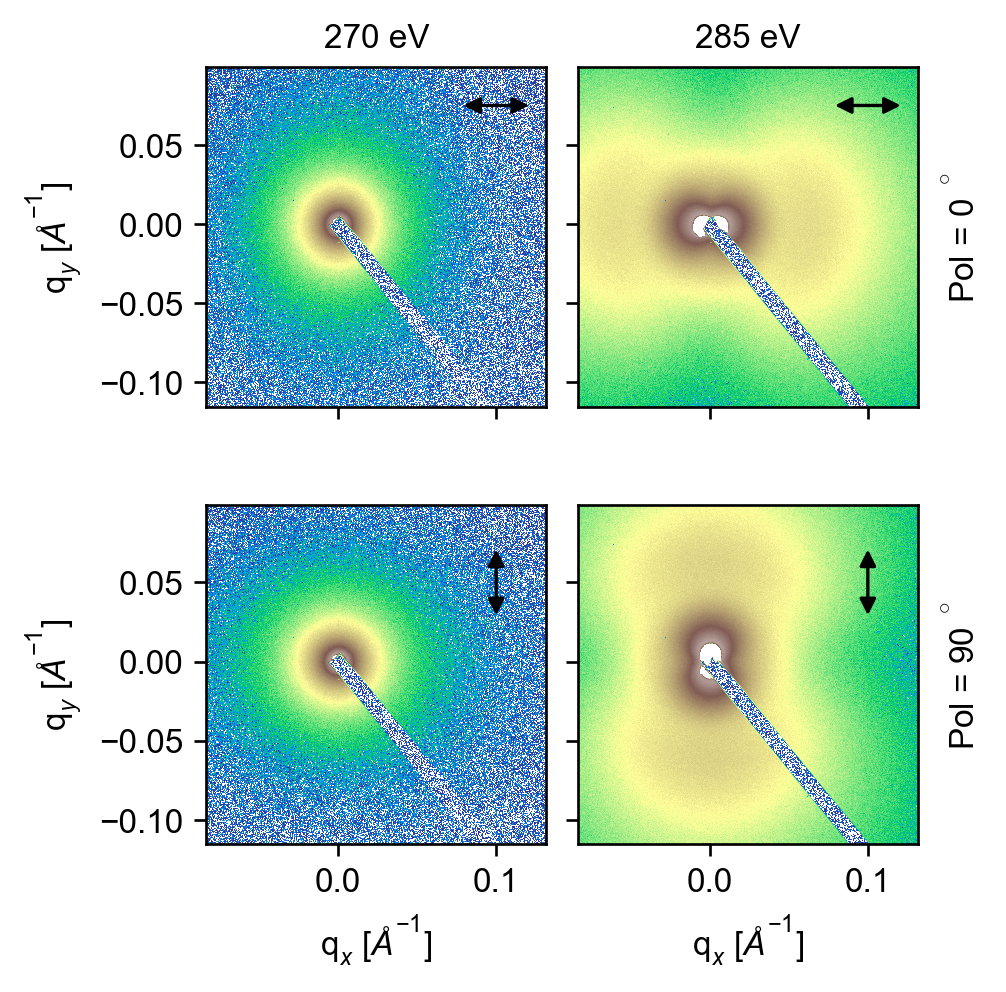

In [25]:
# define q coordinates for plotting
dq = 4*np.pi*np.sin(np.arctan(pol0_waxs.attrs['pixel1']/pol0_waxs.attrs['dist'])/2)/45.9
qx = (np.arange(pol0_waxs.shape[1]) - pol0_waxs.beamcenter_x)*dq
qy = (np.arange(pol0_waxs.shape[0]) - pol0_waxs.beamcenter_y)*dq

plot_kwargs = {'norm':LogNorm(1e1,1e6), 'cmap':'terrain', 'extent':[qx[0], qx[-1], qy[0], qy[-1]], 'origin':'lower', 'interpolation':'none'}
fig, ax = plt.subplots(2,2, dpi=240, figsize=(4,4), constrained_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].imshow(pol0_waxs.sel(energy=270).values, **plot_kwargs)
ax[1].imshow(pol0_waxs.sel(energy=285).values, **plot_kwargs)
ax[2].imshow(pol90_waxs.sel(energy=270).values, **plot_kwargs)
ax[3].imshow(pol90_waxs.sel(energy=285).values, **plot_kwargs)


[{axes.set_title(''), axes.set_xlabel(''), axes.set_ylabel('')} for axes in ax]
ax[0].set_title('270 eV', fontsize=10)
ax[1].set_title('285 eV', fontsize=10)
ax[1].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")
ax[1].set_ylabel('Pol = 0 $^\circ$',fontsize=10,labelpad=8)
ax[3].set_ylabel('Pol = 90 $^\circ$',fontsize=10,labelpad=8)
ax[0].set_ylabel(r'q$_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'q$_y$ [$\AA^{-1}$]')
ax[2].set_xlabel(r'q$_x$ [$\AA^{-1}$]')
ax[3].set_xlabel(r'q$_x$ [$\AA^{-1}$]')

ax[0].annotate("", xytext=(0.075, 0.075), xy=(0.125, 0.075),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))
ax[1].annotate("", xytext=(0.075, 0.075), xy=(0.125, 0.075),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))
ax[2].annotate("", xytext=(0.1, 0.025), xy=(0.1, 0.075),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))
ax[3].annotate("", xytext=(0.1, 0.025), xy=(0.1, 0.075),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))

plt.savefig('Figures/experiment2D.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

Plotting the scattering pattern at 270 eV and 285 eV for both 0 and 90 polarization, we observe isotropic scattering at the non-resonant energy and anisotropic scattering upon resonance. The anisotropy is parallel to the x-ray beam polarization, flipping from horizontal to vertical as polarization goes from 0 to 90. Also note the white area near the beam stop where the detector signal is saturated. This was done purposefully to get better signal in the lower intensity regions of the pattern.

## Data Reduction

The raw scattering patterns collected off the detector have pixel coordinates that we would like to translate into the scattering vector, q, and an azimuthal angle, $\chi$. The PyHyperScattering PFEnergySeriesIntegrator is used to re-mesh, or "integrate", the data into these coordinates based on x-ray energy, sample to detector distance (SDD), and detector pixel size.

### WAXS Data

In [6]:
waxs_integrator = PyHyperScattering.integrate.PFEnergySeriesIntegrator(geomethod='template_xr', template_xr=pol0_waxs)
# update beamcenter. poni stands for point of normal incidence
waxs_integrator.poni1 = 0.03299931
waxs_integrator.poni2 = 0.02378048

/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/PFGeneralIntegrator.py:145: UserWarning: Since mask was none, creating an empty mask with shape (1024, 1026)
  self.calibrationFromTemplateXRParams(template_xr)


A boolean mask is used to discard or ignore areas of the image that we don't want to integrate, like the beamstop. PyHyperScattering has functionality to interactively create a mask, but here we load a previously created one from file.

In [7]:
draw_waxs = PyHyperScattering.IntegrationUtils.DrawMask(pol0_waxs.mean('energy'))
draw_waxs.load('Data/WAXS_mask.json')
waxs_integrator.mask = draw_waxs.mask

/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/IntegrationUtils.py:184: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflist.append(pd.read_json(item))
/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/IntegrationUtils.py:184: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflist.append(pd.read_json(item))
/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/IntegrationUtils.py:184: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflist.append(pd.read_json(item))
/home/pjd/lib/mambaforge/envs/rsox

Each set of images are integrated into the q, $\chi$ coordinate system

In [8]:
pol0_waxs_int = waxs_integrator.integrateImageStack(pol0_waxs)
pol90_waxs_int = waxs_integrator.integrateImageStack(pol90_waxs)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Plotting the integrated image at 285 eV, we can see how the raw detector image has been transformed.

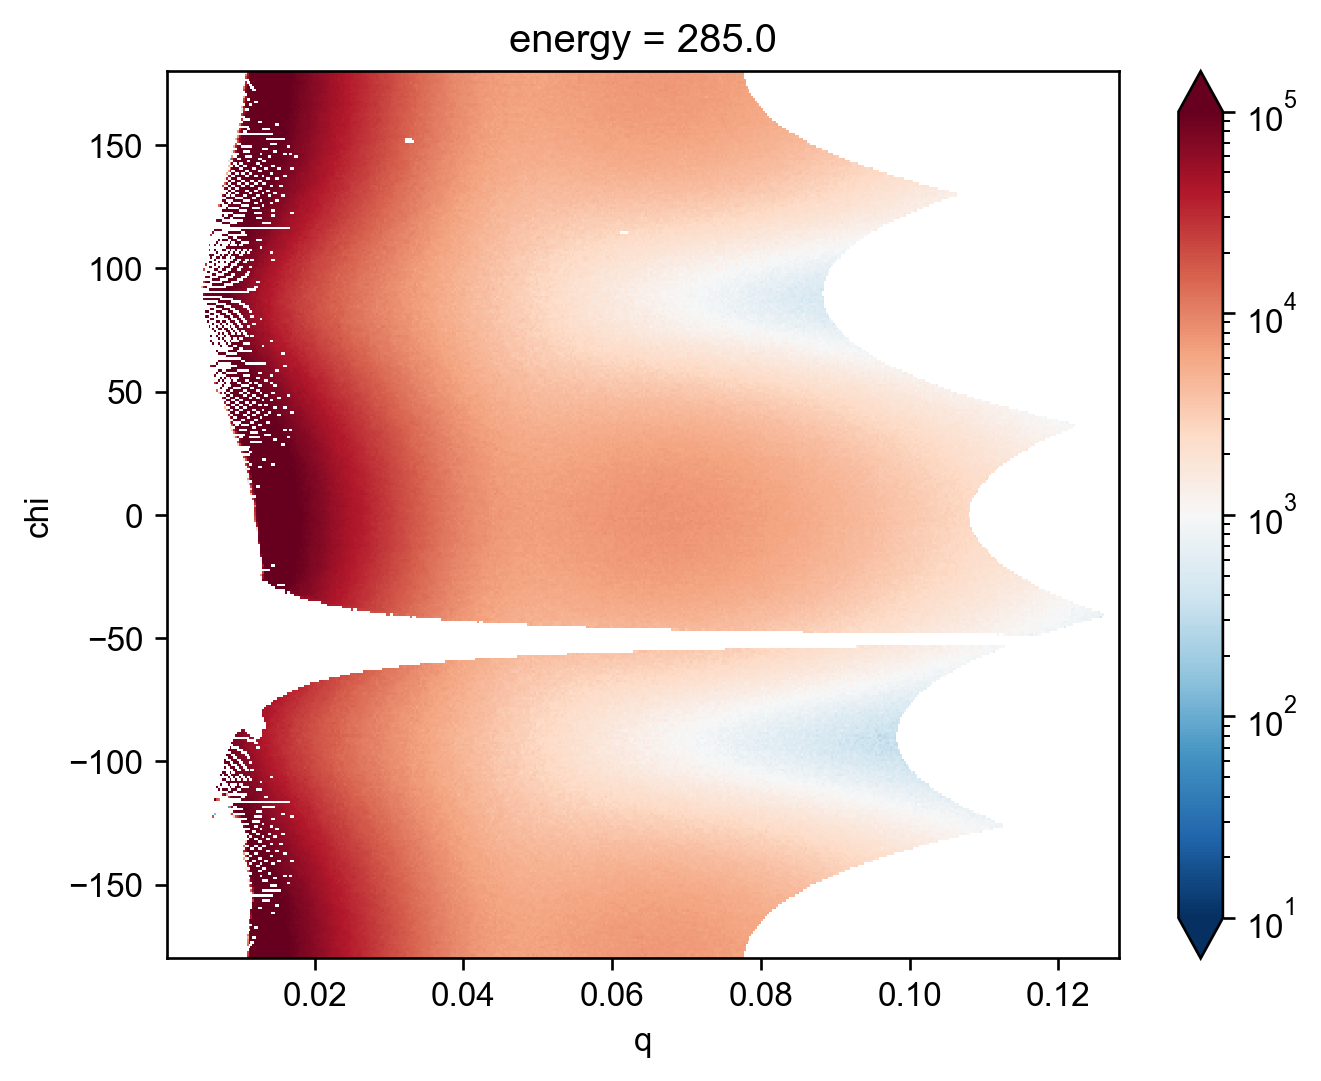

In [9]:
plt.figure(dpi=240)
pol0_waxs_int.sel(energy=285).plot(norm=LogNorm(1e1,1e5))

### SAXS Data

The same steps can be repeated for the scattering patterns collected on the SAXS camera.

In [27]:
pol0_saxs = xr.open_dataarray('Data/RSoXS/CNT_pol0_SAXS_raw.nc')
pol90_saxs = xr.open_dataarray('Data/RSoXS/CNT_pol90_SAXS_raw.nc')

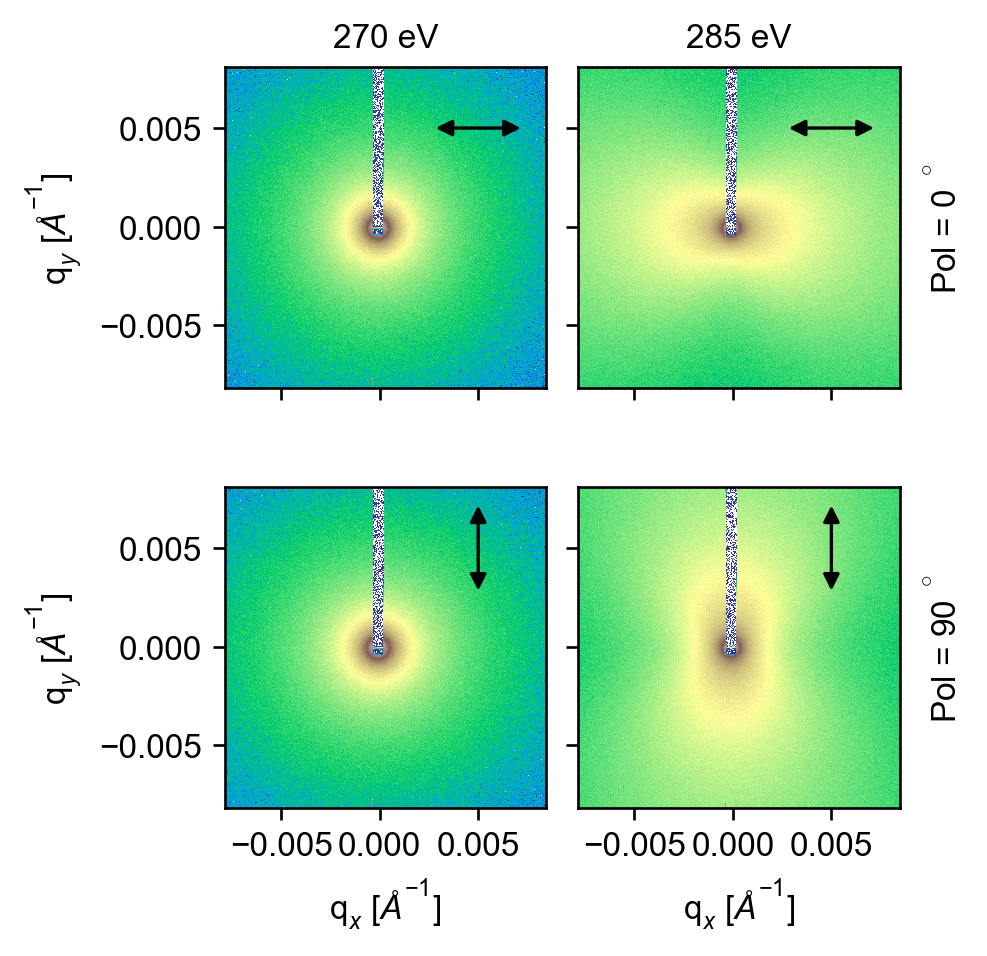

In [35]:
#define q coordinates for plotting
dq = 4*np.pi*np.sin(np.arctan(pol0_saxs.attrs['pixel1']/pol0_saxs.attrs['dist'])/2)/45.9
qx = (np.arange(pol0_saxs.shape[1]) - pol0_saxs.beamcenter_x)*dq
qy = (np.arange(pol0_saxs.shape[0]) - pol0_saxs.beamcenter_y)*dq

plot_kwargs = {'norm':LogNorm(1e1,1e6), 'cmap':'terrain', 'extent':[qx[0], qx[-1], qy[0], qy[-1]], 'origin':'lower', 'interpolation':'none'}
fig, ax = plt.subplots(2,2, dpi=240, figsize=(4,4), constrained_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].imshow(pol0_saxs.sel(energy=270).values, **plot_kwargs)
ax[1].imshow(pol0_saxs.sel(energy=285).values, **plot_kwargs)
ax[2].imshow(pol90_saxs.sel(energy=270).values, **plot_kwargs)
ax[3].imshow(pol90_saxs.sel(energy=285).values, **plot_kwargs)


[{axes.set_title(''), axes.set_xlabel(''), axes.set_ylabel('')} for axes in ax]
ax[0].set_title('270 eV', fontsize=10)
ax[1].set_title('285 eV', fontsize=10)
ax[1].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")
ax[1].set_ylabel('Pol = 0 $^\circ$',fontsize=10,labelpad=8)
ax[3].set_ylabel('Pol = 90 $^\circ$',fontsize=10,labelpad=8)
ax[0].set_ylabel(r'q$_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'q$_y$ [$\AA^{-1}$]')
ax[2].set_xlabel(r'q$_x$ [$\AA^{-1}$]')
ax[3].set_xlabel(r'q$_x$ [$\AA^{-1}$]')

ax[0].annotate("", xytext=(0.0025, 0.005), xy=(0.0075, 0.005),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))
ax[1].annotate("", xytext=(0.0025, 0.005), xy=(0.0075, 0.005),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))
ax[2].annotate("", xytext=(0.005, 0.0025), xy=(0.005, 0.0075),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))
ax[3].annotate("", xytext=(0.005, 0.0025), xy=(0.005, 0.0075),
            arrowprops=dict(arrowstyle="<|-|>",facecolor='k'))

plt.show()

In [29]:
saxs_integrator = PyHyperScattering.integrate.PFEnergySeriesIntegrator(geomethod='template_xr', template_xr=pol0_saxs)

/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/PFGeneralIntegrator.py:145: UserWarning: Since mask was none, creating an empty mask with shape (1024, 1026)
  self.calibrationFromTemplateXRParams(template_xr)


In [57]:
draw_saxs = PyHyperScattering.IntegrationUtils.DrawMask(pol0_saxs.mean('energy'))
draw_saxs.load('Data/SAXS_mask.json')
saxs_integrator.mask = draw_saxs.mask

/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/IntegrationUtils.py:184: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflist.append(pd.read_json(item))
/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/IntegrationUtils.py:184: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflist.append(pd.read_json(item))
/home/pjd/lib/mambaforge/envs/rsoxs_tutorial/lib/python3.11/site-packages/PyHyperScattering/IntegrationUtils.py:184: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflist.append(pd.read_json(item))
/home/pjd/lib/mambaforge/envs/rsox

In [58]:
pol0_saxs_int = saxs_integrator.integrateImageStack(pol0_saxs)

  0%|          | 0/55 [00:00<?, ?it/s]

In [59]:
pol90_saxs_int = saxs_integrator.integrateImageStack(pol90_saxs)

  0%|          | 0/55 [00:00<?, ?it/s]

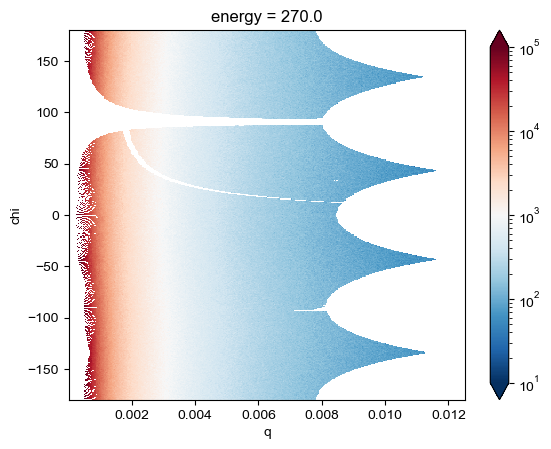

In [60]:
pol0_saxs_int.sel(energy=270).plot(norm=LogNorm(1e1,1e5))

### Further data processing

Once data from both detectors have been integrated into the q, $\chi$ coordinate system, we perform further processing on these data to derive additional quantities. Using the xarray/pandas syntax, we can select and average over regions in $\chi$ to get I(q). These are known as sector cuts

In [61]:
para_waxs_0 = pol0_waxs_int.sel(chi=slice(-20,20)).mean('chi')
perp_waxs_0 = pol0_waxs_int.sel(chi=slice(-110,-70)).mean('chi')

para_saxs_0 = pol0_saxs_int.sel(chi=slice(-20,20)).mean('chi')
perp_saxs_0 = pol0_saxs_int.sel(chi=slice(-110,-70)).mean('chi')

We can plot the sector cuts for the SAXS and WAXS data for the 0-polarization, parallel and perpendicular to the x-ray beam polarization. We  see that at 270 eV, the parallel and perpendicular sector cuts overlap, indicative of the isotropic scattering. At 285 eV, the parallel sector cut shows strong form factor scattering from the MWCNTs, while the perpendicular sector cut does not. This again illustrates the anisotropic scattering that was clearly present in the raw 2D images.

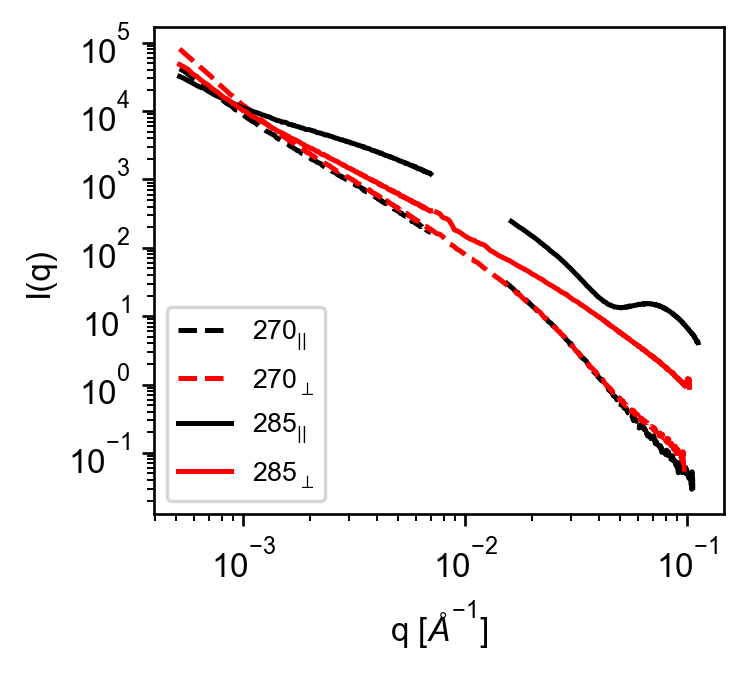

In [81]:
fig, ax = plt.subplots(dpi=240, figsize=(3, 2.7), layout='constrained')
para_saxs_0.sel(energy=270, q=slice(5e-4,7e-3)).plot(yscale='log',xscale='log', color='k',ax=ax, linewidth=1.5, linestyle='--')
perp_saxs_0.sel(energy=270, q=slice(5e-4,7e-3)).plot(yscale='log',xscale='log', color='r',ax=ax,linewidth=1.5, linestyle='--')
para_saxs_0.sel(energy=285, q=slice(5e-4,7e-3)).plot(yscale='log',xscale='log', color='k',ax=ax, linewidth=1.5)
perp_saxs_0.sel(energy=285, q=slice(5e-4,7e-3)).plot(yscale='log',xscale='log', color='r',ax=ax,linewidth=1.5)


(para_waxs_0.sel(energy=270,q=slice(1.5e-2,.2))/.5e3).plot(color='k',ax=ax,linewidth=1.5, linestyle='--')
(perp_waxs_0.sel(energy=270)/.5e3).plot(color='r',ax=ax,linewidth=1.5, linestyle='--')
(para_waxs_0.sel(energy=285,q=slice(1.6e-2,.2))/.5e3).plot(color='k',ax=ax,linewidth=1.5)
(perp_waxs_0.sel(energy=285)/.5e3).plot(color='r',ax=ax, linewidth=1.5)


ax.set_xlabel('q [$\AA^{-1}$]', fontdict={'fontfamily':'Arial'})
ax.set_ylabel('I(q)')
ax.set_title('')

ax.legend([r'270$_{||}$',r'270$_{\perp}$',r'285$_{||}$',r'285$_{\perp}$'],fontsize=8, loc='lower left')
plt.savefig('Figures/experimental1D.pdf', format='pdf', bbox_inches='tight')
plt.show()

Using the parallel and perpendicular sector cuts, we can derive the anisotropy ratio, A, which is defined as $$ A = \frac{I_{||} - I_{\perp}}{I_{||} + I_{\perp}}$$

In [63]:
A_waxs = (para_waxs_0 - perp_waxs_0) / (para_waxs_0  + perp_waxs_0)
A_waxs = A_waxs.where(A_waxs.q > 0.015)

A_saxs = (para_saxs_0 - perp_saxs_0) / (para_saxs_0 + perp_saxs_0)

Plotting the anisotropy ratio as a function of q and energy provides a 2D map that can be thought of as a spectral fingerprint for the sample. Areas of negative or positive anisotropy will vary in q and energy depending on the contrast mechanisms present in the sample, and on what lengthscales those mechanisms occur. Here we see strong positive anisotropy from ~280 eV to 290 eV, where there is a strong $\pi^*$ resonance in the MWCNT dielectric function. At higher energies, A oscillates between negative and positive in accordance with additional resonances in the dielectric function. Much of the structure observed here is at higher-q, at similar lengthscales to the diameters of the MWCNTs.

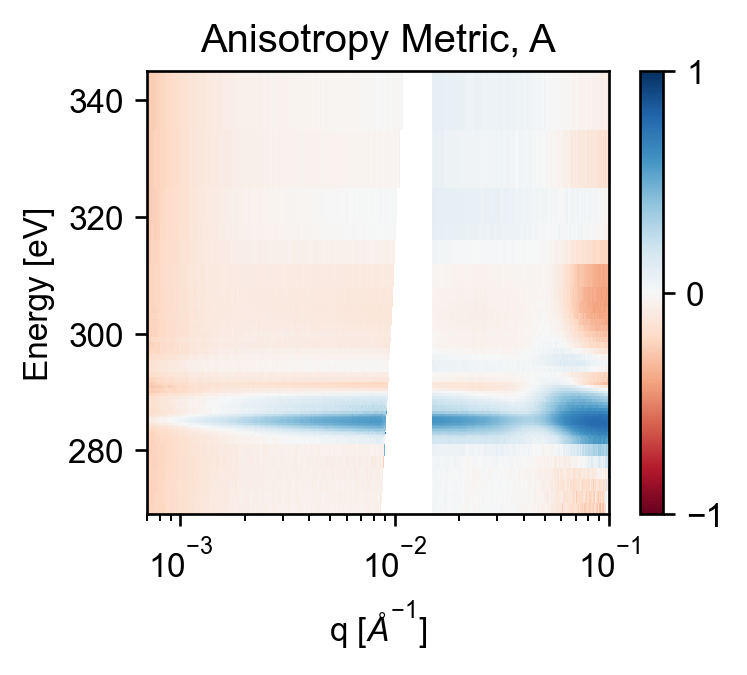

In [102]:
plt.figure(dpi=240, figsize=(3,2.7), constrained_layout=True)
A_waxs.plot(cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'ticks':[-1, 0, 1], 'pad':0.001})
A_saxs.plot(cmap='RdBu', vmin=-1, vmax=1, add_colorbar=False)
plt.xscale('log')
plt.xlim(7e-4, 1e-1)
plt.xlabel('q [$\AA^{-1}$]', fontdict={'fontfamily':'Arial'})
plt.ylabel('Energy [eV]')
plt.title('Anisotropy Metric, A')
plt.savefig('Figures/ExperimentA.pdf', format='pdf', bbox_inches='tight')
plt.show()

In addition to the anisotropy ratio, we can also integrate the scattering signal over $\chi$ and q to calculate the integrated scattered intensity, or ISI(E). This quantity provides information on the dominant scattering contrast mechanisms as a funtion of energy. Below we plot ISI(E) integrated over different q-ranges, which show different energy dependence.

$$ISI(E) = \int\int I(q,\chi,E)\ d\chi\ q^2\ dq$$

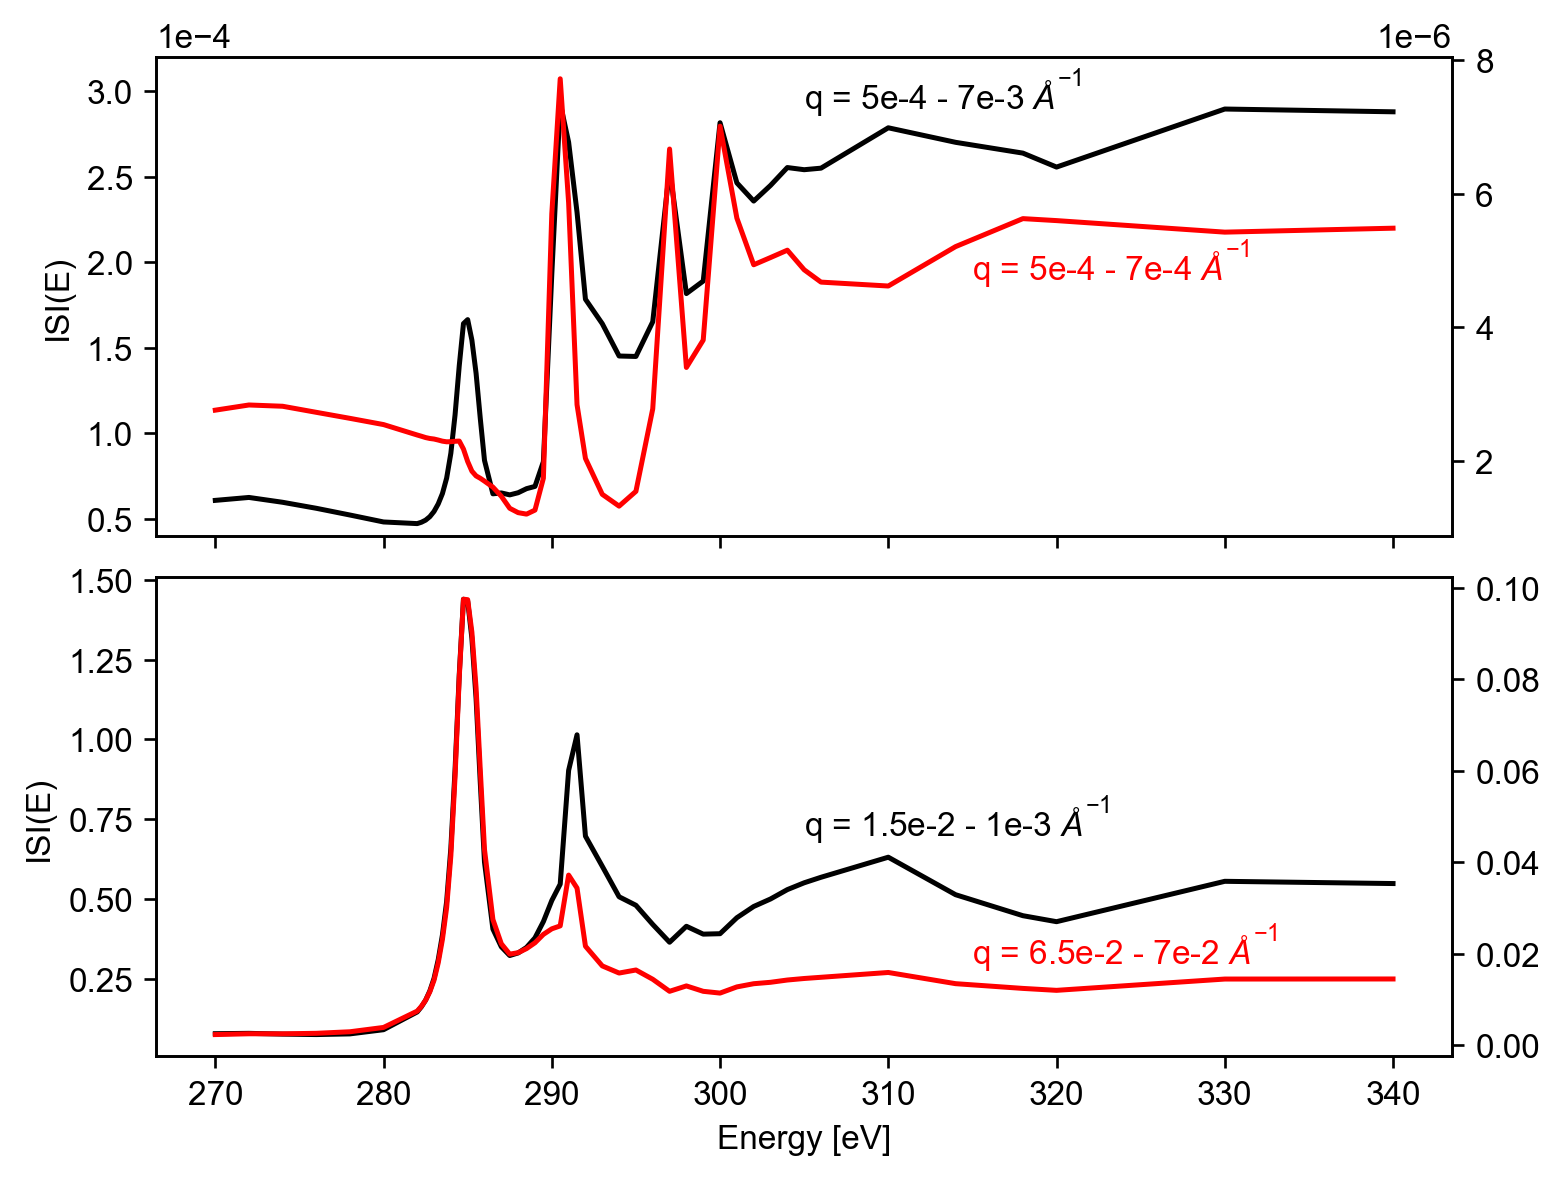

In [87]:
fig, ax = plt.subplots(2,1, dpi=240, constrained_layout=True, sharex=True)
(pol0_saxs_int*pol0_saxs_int.q**2).sel(q=slice(5e-4,7e-3)).mean('chi').integrate('q').plot(color='k',ax=ax[0])
ax[0].ticklabel_format(axis='y', scilimits=[0,0])
ax02=ax[0].twinx()
(pol0_saxs_int*pol0_saxs_int.q**2).sel(q=slice(5e-4,7e-4)).mean('chi').integrate('q').plot(ax=ax02,color='r')

(pol0_waxs_int*pol0_waxs_int.q**2).sel(q=slice(0.015,0.1)).mean('chi').integrate('q').plot(color='k',ax=ax[1])
ax12=ax[1].twinx()
(pol0_waxs_int*pol0_waxs_int.q**2).sel(q=slice(0.065,0.07)).mean('chi').integrate('q').plot(ax=ax12,color='r')

ax[0].set_xlabel('')
ax[1].set_xlabel('Energy [eV]')
ax[0].set_ylabel('ISI(E)')
ax[1].set_ylabel('ISI(E)')
ax[0].set_ylim(0.4e-4, 3.2e-4)

ax[0].text(305,2.9e-4, 'q = 5e-4 - 7e-3 $\AA^{-1}$', fontdict={'fontfamily':'Arial'})
ax[0].text(315,1.9e-4, 'q = 5e-4 - 7e-4 $\AA^{-1}$',color='r', fontdict={'fontfamily':'Arial'})

ax[1].text(305,0.7, 'q = 1.5e-2 - 1e-3 $\AA^{-1}$')
ax[1].text(315,0.3, 'q = 6.5e-2 - 7e-2 $\AA^{-1}$',color='r', fontdict={'fontfamily':'Arial'})
plt.show()

Below we create the ISI figure in the paper.

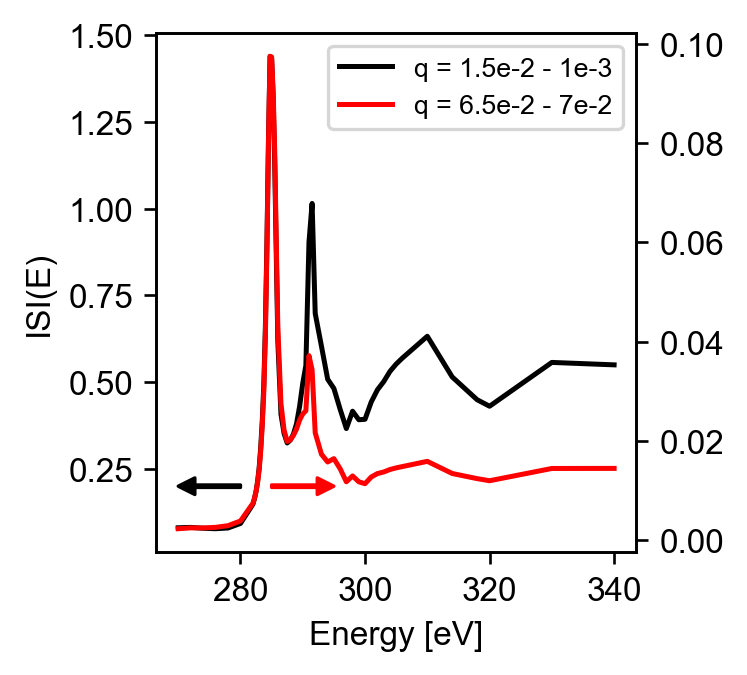

In [84]:
fig, ax = plt.subplots(dpi=240, figsize=(3, 2.7), layout='constrained')
(pol0_waxs_int*pol0_waxs_int.q**2).sel(q=slice(0.015,0.1)).mean('chi').integrate('q').plot(color='k',ax=ax)
plt.plot([270], [1],color='r')
# plt.ylim(0)
plt.xlabel('Energy [eV]')
plt.ylabel('ISI(E)')
plt.legend(['q = 1.5e-2 - 1e-3', 'q = 6.5e-2 - 7e-2'], fontsize=8)
ax2 = ax.twinx()
(pol0_waxs_int*pol0_waxs_int.q**2).sel(q=slice(0.065,0.07)).mean('chi').integrate('q').plot(color='r',ax=ax2)
ax.annotate('', xy=(270, 0.2), xytext=(280,0.2), arrowprops=dict(color='k', width=0.75, headwidth=5, headlength=5))
ax.annotate('', xy=(295, 0.2), xytext=(285,0.2), arrowprops=dict(color='r', width=0.75, headwidth=5, headlength=5))
# ax2.set_ylabel('ISI(E)')
plt.savefig('Figures/experimentISI.pdf', format='pdf', bbox_inches='tight')
plt.show()

We save the reduced SAXS and WAXS data at polarization = 0 for use in notebook 3.

In [67]:
pol0_saxs_int.to_netcdf('Data/RSoXS/CNT_pol0_SAXS.nc')
pol0_waxs_int.to_netcdf('Data/RSoXS/CNT_pol0_WAXS.nc')

### Absorption Data

With every RSoXS scattering pattern collected at SST-1, the diode on the beamstop collects the transmitted beam intensity. In conjuction with a calibration scan, this can be used to calculated the Transmission/Absorption of a sample. The correct reference/calibration scan must be used for accurate calculation of this quantity, as we demonstrate below. Using a vacuum scan will calculate the Transmission of the sample + SiN support window. But we are interested in just the Transmission of the sample itself.

If a vacuum reference scan is all that is available, then you can correct the vacuum scan by calculating the absorption of the SiN window using optical constants from the Henke X-ray Database (https://henke.lbl.gov/optical_constants/).

In [68]:
sample_diode = pd.read_csv('Data/RSoXS/SampleDiode_48674.csv', index_col=False)
vacuum_diode = pd.read_csv('Data/RSoXS/CalibrationScan_48564.csv', index_col=False)
nitride_diode = pd.read_csv('Data/RSoXS/NitrideCalibration_48218.csv', index_col=False)
SiN_consts = pd.read_csv('Data/RSoXS/SiN_deltabeta.csv', index_col=False)

In [69]:
nitride_correction = nitride_diode['mesh']/nitride_diode['diode']
vacuum_correction = np.interp(sample_diode['energy'], vacuum_diode['energy'], vacuum_diode['mesh']/vacuum_diode['diode'])

#vacuum nitride correction
I_SiN = np.exp(-100*4*np.pi*SiN_consts['beta']/SiN_consts['wvl'])
I_SiN = np.interp(sample_diode['energy'], SiN_consts['Energy'], I_SiN)

Below you can see the Transmission calculated from the vacuum reference scan, the SiN reference scan, and the vacuum reference scan after correction with expected SiN absorption. The corrected vacuum scan and SiN reference scan agree nicely.

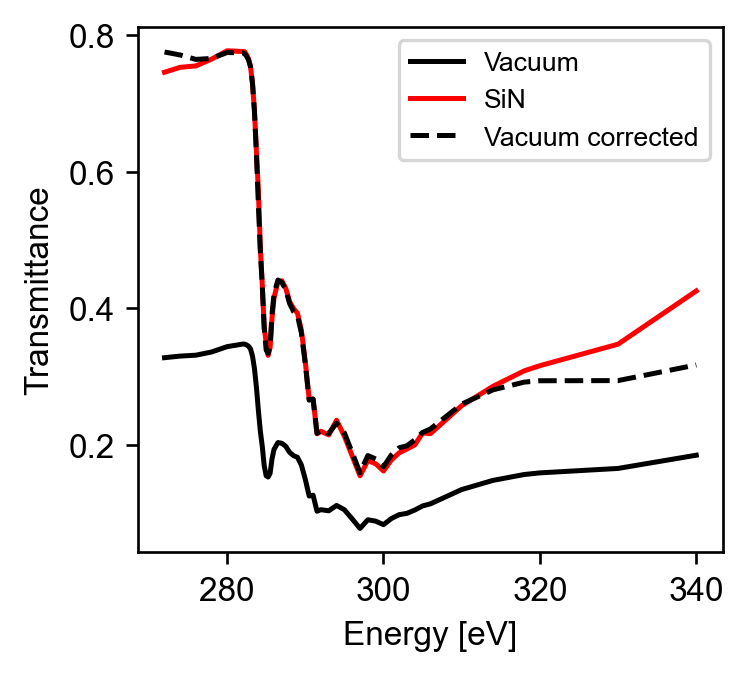

In [103]:
fig, ax = plt.subplots(dpi=240, figsize=(3, 2.7), layout='constrained')
plt.plot(sample_diode['energy'], sample_diode['diode']/sample_diode['mesh']*vacuum_correction,'k')
plt.plot(sample_diode['energy'], sample_diode['diode']/sample_diode['mesh']*nitride_correction, color='r')
plt.plot(sample_diode['energy'], sample_diode['diode']/sample_diode['mesh']*(vacuum_correction/I_SiN), color='k', linestyle='--', zorder=10)

# plt.ylim(0,1.15)
plt.legend(['Vacuum',  'SiN', 'Vacuum corrected'], fontsize=8, loc='upper right')
plt.xlabel('Energy [eV]')
plt.ylabel('Transmittance')
plt.savefig('Figures/SampleTransmittance.pdf', format='pdf', bbox_inches='tight')
plt.show()